In [1]:
from heeps.config import read_config, update_config
from heeps.pupil.create_petal import create_petal
from heeps.util.freq_decomp import get_zernike, remove_zernike
from heeps.util.multiCPU import multiCPU
from heeps.util.img_processing import resize_cube
from copy import deepcopy
import os
from astropy.io import fits
import numpy as np
import proper
import matplotlib.pyplot as plt
%matplotlib inline

### Load SCAO cube

In [2]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/wavefront/cfull')))
band = 'L'
nzer = 3
npetals = 6
scao = 'cube_Cfull_20220512_3600s_300ms_0piston_meters_scao_only_%s_%s.fits'
mask = 'mask_Cfull_20220512_%s_%s.fits'
npupil = {}
for b in ['L', 'M', 'N1', 'N2']:
    npupil[b] = update_config(**dict(read_config(), band=b))['npupil']
print('npupil = %s'%npupil)
cube_name = scao%(band, npupil[band])
pup = fits.getdata(mask%(band, npupil[band]))
pup[pup < .5] = 0
cube = fits.getdata(cube_name)

npupil = {'L': 285, 'M': 227, 'N1': 155, 'N2': 119}


### Remove tip/tilt

getdata cube_Cfull_20220512_3600s_300ms_0piston_meters_scao_only_L_285_zpols_3.fits


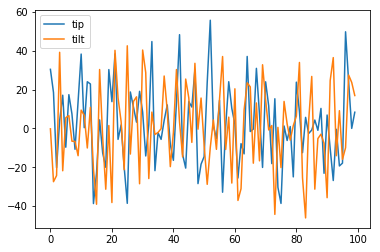

In [3]:
zpols = get_zernike(cube_name, pup, nzer)
plt.plot(zpols[:100,1]*1e9, label='tip')
plt.plot(zpols[:100,2]*1e9, label='tilt')
plt.legend();

In [4]:
wf = proper.prop_begin(1, 1, npupil[band], 1) # initial wavefront
LSF, HSF = multiCPU(remove_zernike, posargs=[deepcopy(wf), pup],
                        posvars=[cube, zpols], case='remove zernike', 
                        multi_out=True, verbose=True)

   2022-06-21 23:04:58, remove zernike using 56 cores
   2022-06-21 23:05:54, completed in 56.28 seconds


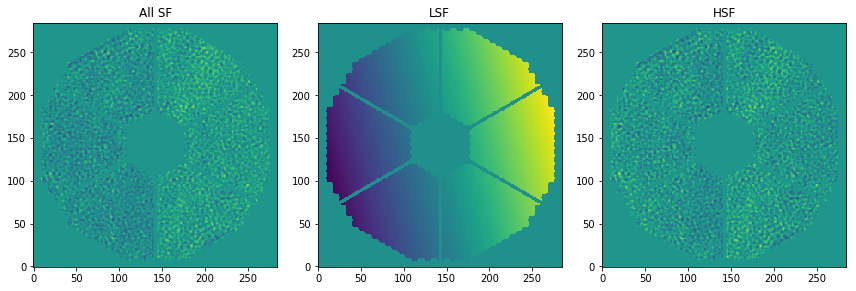

In [5]:
iframe = 10
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))
ax1.imshow(cube[iframe], origin='lower');
ax1.set_title('All SF')
ax2.imshow(LSF[iframe], origin='lower');
ax2.set_title('LSF')
ax3.imshow(HSF[iframe], origin='lower');
ax3.set_title('HSF')
fig.tight_layout()

### One frame petal piston

In [6]:
petals = np.float32([create_petal(x, npetals, npupil[band]) for x in range(npetals)])
frame = 1*HSF[iframe]
for i, petal in enumerate(petals):
    print('petal %s, piston = '%(i+1), end='')
    petal_frame = petal*frame
    piston = np.mean(petal_frame[petal_frame != 0])
    print('%.2fnm'%(piston*1e9))
    frame[petal_frame!=0] -= piston

petal 1, piston = -12.69nm
petal 2, piston = 21.77nm
petal 3, piston = -13.47nm
petal 4, piston = -0.09nm
petal 5, piston = -19.85nm
petal 6, piston = 24.26nm


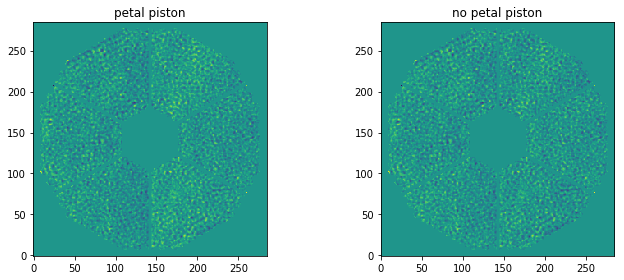

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.imshow(HSF[iframe], origin='lower');
ax1.set_title('petal piston')
ax2.imshow(frame, origin='lower');
ax2.set_title('no petal piston')
fig.tight_layout()

### Remove petal piston from full cube

In [8]:
for i, petal in enumerate(petals):
    print(i, end=', ')
    for frame in HSF:
        petal_frame = petal*frame
        piston = np.mean(petal_frame[petal_frame != 0])
        frame[petal_frame!=0] -= piston

0, 1, 2, 3, 4, 5, 

In [9]:
for b in ['L', 'M', 'N1', 'N2']:
    fits.writeto(scao[:-5]%(b, npupil[b]) + '_noTTnoPP.fits', 
        resize_cube(HSF, npupil[b]), overwrite=True)